In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import warnings

# hide warnings
warnings.filterwarnings("ignore")

In [ ]:
from sktime.datasets._single_problem_loaders import load_m5

extract_path = ""
dataset = load_m5(extract_path=, include_events=True, merged=True)
with open('dataset_with_events.pkl', 'wb') as file:
    pickle.dump(dataset, file)
    print("Dataset Saved")

In [ ]:
with open('dataset_with_events.pkl', 'rb') as file:
    data = pickle.load(file)
    print("Dataset Loaded")

In [ ]:
# Feature engineering
from sktime.transformations.series.lag import Lag

data['sell_price'] = data['sell_price'].fillna(0)
# data['sell_price'] = data['sell_price'].astype(float).round(2)

f=lambda x: 1 if x==7 or x==1 or x==2 else 0
data['is_high_sale_day']=data['wday'].map(f) 

f=lambda x: 1 if x==2 or x==3 or x==4 or x==5 else 0
data['is_high_sale_months']=data['month'].map(f) 

f=lambda x: 1 if x=='Christmas' else 0
data['is_christmas']=data['event_name_1'].map(f)

# lags using Lag transformer
lags = [1, 7, 14, 21, 28] 
lag_transformer = Lag(lags=lags)
# Apply the lag transformation
lag_df = lag_transformer.fit_transform(data[['sales']])
lag_df = lag_df.fillna(0)
for lag in lags:
    data[f'lag_{lag}'] = lag_df[f'lag_{lag}__sales']

# Adding window feature
window=[7,14,21,28]
for i in window:
    data['rolling_mean_'+str(i)]=data.groupby(['item_id'])['sales'].transform(lambda s: s.rolling(i).mean())

window=['rolling_mean_7','rolling_mean_14', 'rolling_mean_7' ,'rolling_mean_21', 'rolling_mean_28']
for i in window:
    data[i]=data[i].fillna(0)

# Expading mean
data['expanding_mean']=data.groupby(['id'])['sales'].transform(lambda s: s.expanding().mean())
data['expanding_mean']=data['expanding_mean'].fillna(0)

cols_to_convert = ['event_type_1', 'event_type_2']
data[cols_to_convert] = data[cols_to_convert].apply(lambda x: x.astype('category').cat.codes + 1)

data=data.drop(
    ['event_name_1','event_name_2', 'item_id','wday','month', 'wm_yr_wk','year'],
    axis = 1,
)

with open('m5_dataset.pkl', 'wb') as file:
    pickle.dump(data, file)
    print("Dataset Saved")

### with a single item

In [ ]:
with open('m5_dataset.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
    print("Dataset Loaded")

In [ ]:
final_data = loaded_data[loaded_data['id'] == 'FOODS_3_090_CA_2_validation']
cols_to_convert = ['id']
final_data[cols_to_convert] = final_data[cols_to_convert].apply(lambda x: x.astype('category').cat.codes)
final_data

id   day  sales  event_type_1  \
state_id store_id cat_id dept_id date                                          
1        2        1      3       2011-01-29  7021     1    116             0   
                                 2011-01-30  7021     2     90             0   
                                 2011-01-31  7021     3     35             0   
                                 2011-02-01  7021     4     33             0   
                                 2011-02-02  7021     5     26             0   
...                                           ...   ...    ...           ...   
                                 2016-04-20  7021  1909     40             0   
                                 2016-04-21  7021  1910     24             0   
                                 2016-04-22  7021  1911     91             0   
                                 2016-04-23  7021  1912     73             0   
                                 2016-04-24  7021  1913     60             0   

                                             event_type_2  sell_price  \
state_id store_id cat_id dept_id date                                   
1        2        1      3       2011-01-29             0    1.250000   
                                 2011-01-30             0    1.250000   
                                 2011-01-31             0    1.250000   
                                 2011-02-01             0    1.250000   
                                 2011-02-02             0    1.250000   
...                                                   ...         ...   
                                 2016-04-20             0    1.599609   
                                 2016-04-21             0    1.599609   
                                 2016-04-22             0    1.599609   
                                 2016-04-23             0    1.599609   
                                 2016-04-24             0    1.599609   

                                             is_high_sale_day  \
state_id store_id cat_id dept_id date                           
1        2        1      3       2011-01-29                 1   
                                 2011-01-30                 1   
                                 2011-01-31                 0   
                                 2011-02-01                 0   
                                 2011-02-02                 0   
...                                                       ...   
                                 2016-04-20                 0   
                                 2016-04-21                 0   
                                 2016-04-22                 1   
                                 2016-04-23                 1   
                                 2016-04-24                 1   

                                             is_high_sale_months  \
state_id store_id cat_id dept_id date                              
1        2        1      3       2011-01-29                    0   
                                 2011-01-30                    0   
                                 2011-01-31                    0   
                                 2011-02-01                    1   
                                 2011-02-02                    1   
...                                                          ...   
                                 2016-04-20                    1   
                                 2016-04-21                    1   
                                 2016-04-22                    1   
                                 2016-04-23                    1   
                                 2016-04-24                    1   

                                             is_christmas  lag_1  lag_7  \
state_id store_id cat_id dept_id date                                     
1        2        1      3       2011-01-29             0   42.0   30.0   
                                 2011-01-30             0  116.0   45.0   
                         

In [ ]:
# Splitting into Endogeneous and Exogeneous data

X =final_data.drop(columns=['day','sales'], axis=1) 
y = final_data[['sales']]

In [ ]:
# Train and Test split
from sktime.forecasting.model_selection import temporal_train_test_split

X_train, x_test, Y_train, y_test = temporal_train_test_split(X,y)

def load():
    return (y, X)

In [ ]:
from sktime.datatypes._check import check_raise

check_raise(y, mtype='pd_multiindex_hier', scitype='Hierarchical'), check_raise(X, mtype='pd_multiindex_hier', scitype='Hierarchical')

(True, True)

In [ ]:
# error terms
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError

smape = MeanAbsolutePercentageError(symmetric=True, multilevel="raw_values")
rmse = MeanSquaredError(multioutput='raw_values', square_root=False)

In [ ]:
from sktime.benchmarking.forecasting import ForecastingBenchmark
from sktime.split import ExpandingWindowSplitter
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

cv = ExpandingWindowSplitter(initial_window=60, step_length=24, fh=np.arange(1, 25))

benchmark = ForecastingBenchmark()
fh = list(range(1, len(y_test) + 1))
benchmark.add_estimator(NaiveForecaster(strategy='mean'))
benchmark.add_estimator(ExponentialSmoothing())
benchmark.add_estimator(AutoETS(auto=True))

benchmark.add_task(dataset_loader=load, cv_splitter=cv, scorers=[MeanAbsolutePercentageError()], task_id="M5_smape")
benchmark.run(output_file='results.txt')

In [ ]:
benchmark.run(output_file='results.txt')

,validation_id,model_id,runtime_secs,MeanAbsolutePercentageError_fold_0_test,MeanAbsolutePercentageError_fold_1_test,MeanAbsolutePercentageError_fold_2_test,MeanAbsolutePercentageError_fold_3_test,MeanAbsolutePercentageError_fold_4_test,MeanAbsolutePercentageError_fold_5_test,MeanAbsolutePercentageError_fold_6_test,...,MeanAbsolutePercentageError_fold_69_test,MeanAbsolutePercentageError_fold_70_test,MeanAbsolutePercentageError_fold_71_test,MeanAbsolutePercentageError_fold_72_test,MeanAbsolutePercentageError_fold_73_test,MeanAbsolutePercentageError_fold_74_test,MeanAbsolutePercentageError_fold_75_test,MeanAbsolutePercentageError_fold_76_test,MeanAbsolutePercentageError_mean,MeanAbsolutePercentageError_std
0,M5_smape,AutoETS,4.419062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.317002e+15,1.205287e+15,3.773010e+14,2.236752e+15,1.705594e+15,1.262915e+15,1.467182e+15,1.316784e+15,1.384215e+15,1.358178e+15
1,M5_smape,ExponentialSmoothing,3.250205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.317001e+15,1.205290e+15,3.773001e+14,2.236761e+15,1.705587e+15,1.262915e+15,1.467182e+15,1.316784e+15,1.150518e+15,1.342209e+15
2,M5_smape,NaiveForecaster,2.586395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.739877e+14,3.853295e+14,1.315890e+14,6.790243e+14,6.917781e+14,5.629500e+14,5.738458e+14,5.852608e+14,3.875697e+14,3.194107e+14


In [ ]:
# function to plot the test data with the prediction
from sktime.utils.plotting import plot_series

def plot_pred(y_test, y_pred):
    y_test_plot = y_test.reset_index().set_index('date')
    y_test_plot = y_test_plot.drop(['state_id','store_id','cat_id','dept_id'],axis =1)
    
    y_pred_plot = y_pred.reset_index().set_index('date')
    y_pred_plot = y_pred_plot.drop(['state_id','store_id','cat_id','dept_id'],axis =1)

    plot_series(y_test_plot, y_pred_plot , labels=['test', 'prediction'])

In [ ]:
# RamdomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV

regressor = RandomForestRegressor(n_estimators=100)
forecaster = make_reduction(regressor, strategy="recursive", pooling="global")
forecaster.fit(Y_train, X=X_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                     pooling='global')

,,,,MeanAbsolutePercentageError
1,2,1,3,0.626847


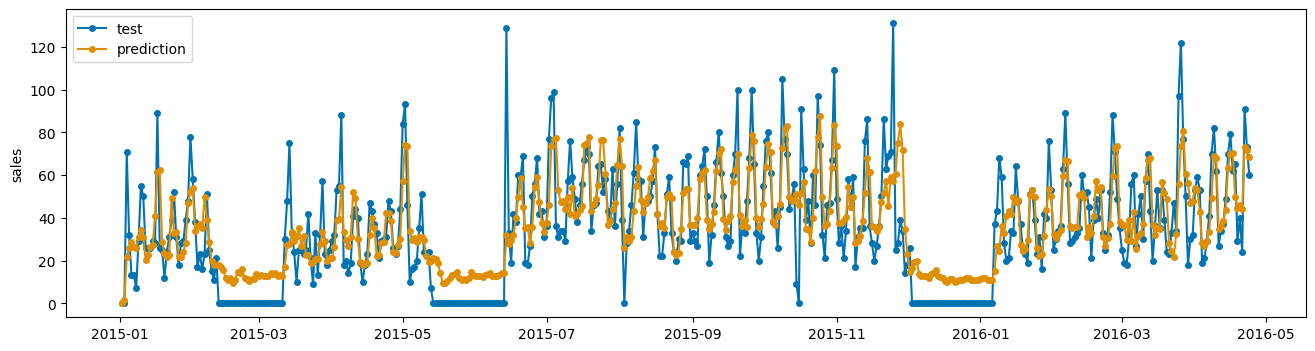

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = forecaster.predict(fh = fh, X=x_test)
plot_pred(y_test, y_pred)
smape(y_test, y_pred)

In [ ]:
from lightgbm import LGBMRegressor

regressor = LGBMRegressor(objective= 'poisson')
forecaster= make_reduction(regressor, strategy = 'recursive', pooling = 'global')

params_grid = {
    'learning_rate' : [0.4, 1, 2],
    'n_estimators' : [50, 75, 100],
}

cv = ExpandingWindowSplitter(initial_window=60, step_length=24, fh=np.arange(1, 25))

gscv = ForecastingGridSearchCV(
    forecaster, 
    cv=cv, 
    param_grid=params_grid,
)

gscv.fit(Y_train, X = X_train)
gscv.best_params_ , gscv.best_score_

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 1424, number of used features: 24
[LightGBM] [Info] Start training from score 3.309399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 1424, number of used features: 24
[LightGBM] [Info] Start training from score 3.309399


({'learning_rate': 1, 'n_estimators': 100}, np.float64(4354660942956363.0))

,,,,MeanAbsolutePercentageError
1,2,1,3,0.393839


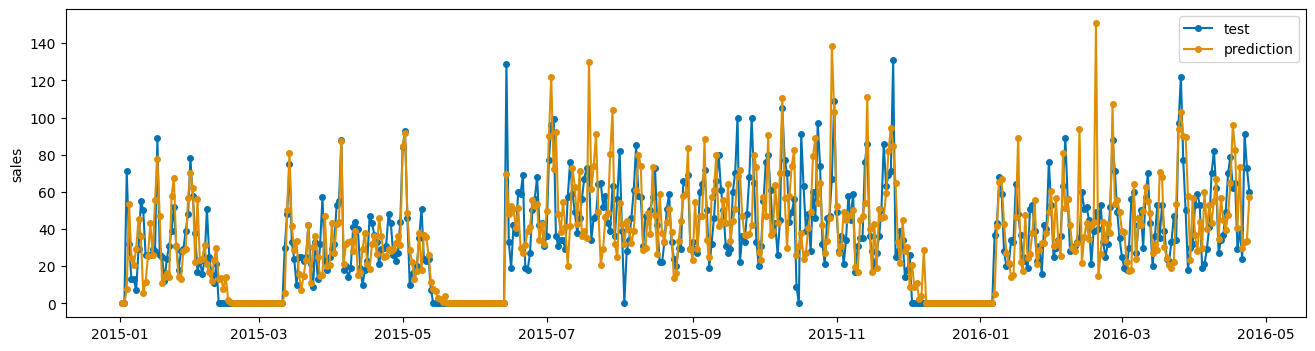

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = gscv.predict(X= x_test, fh=fh)
plot_pred(y_test, y_pred)
smape(y_test.round(), y_pred.round())

In [ ]:
# ReconcilerForecaster
from sktime.forecasting.reconcile import ReconcilerForecaster

reconciler = ReconcilerForecaster(forecaster, method = "ols")
reconciler.fit(Y_train, X=X_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2651
[LightGBM] [Info] Number of data points in the train set: 2848, number of used features: 24
[LightGBM] [Info] Start training from score 3.309399


ReconcilerForecaster(forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(objective='poisson'),
                                                                     pooling='global'),
                     method='ols')

,,,,MeanAbsolutePercentageError
1,2,1,3,0.322572


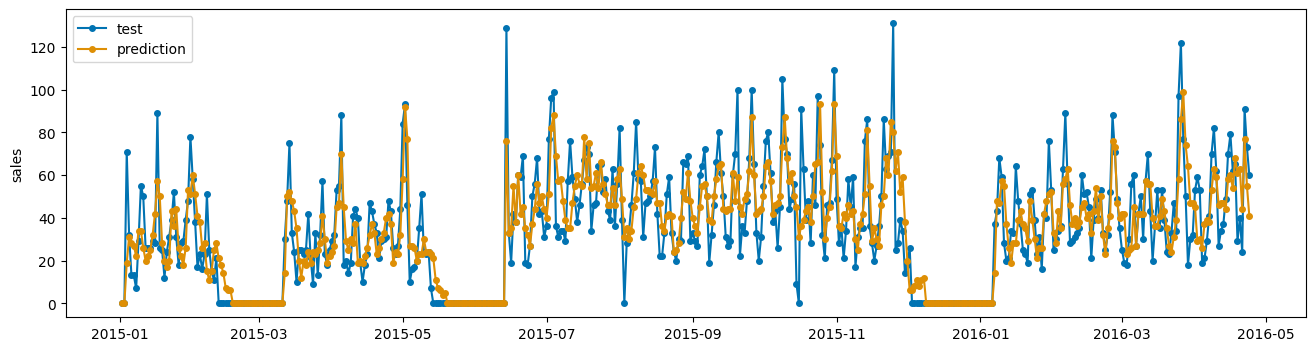

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = reconciler.predict(X= x_test, fh=fh)
plot_pred(y_test, y_pred[:479].round())
smape(y_test, y_pred[:479].round())

### with multiple items

In [ ]:
from sktime.forecasting.reconcile import ReconcilerForecaster

In [ ]:
hier_data = loaded_data[(loaded_data['id'] == 'FOODS_3_140_CA_2_validation') 
                        | (loaded_data['id'] == 'FOODS_3_090_CA_2_validation') 
                        | (loaded_data['id'] == 'HOUSEHOLD_2_512_WI_3_validation')]

# cols_to_convert = ['id']
# hier_data[cols_to_convert] = hier_data[cols_to_convert].apply(lambda x: x.astype('category').cat.codes)

hier_data.set_index('id', append=True, inplace=True)
hier_data = hier_data.reorder_levels(['state_id', 'store_id', 'cat_id', 'dept_id', 'id', 'date'])
hier_data.sort_index(inplace=True)

In [ ]:
hier_data

day  \
state_id store_id cat_id dept_id id                              date               
1        2        1      3       FOODS_3_090_CA_2_validation     2011-01-29     1   
                                                                 2011-01-30     2   
                                                                 2011-01-31     3   
                                                                 2011-02-01     4   
                                                                 2011-02-02     5   
...                                                                           ...   
3        10       3      7       HOUSEHOLD_2_512_WI_3_validation 2016-04-20  1909   
                                                                 2016-04-21  1910   
                                                                 2016-04-22  1911   
                                                                 2016-04-23  1912   
                                                                 2016-04-24  1913   

                                                                             sales  \
state_id store_id cat_id dept_id id                              date                
1        2        1      3       FOODS_3_090_CA_2_validation     2011-01-29    116   
                                                                 2011-01-30     90   
                                                                 2011-01-31     35   
                                                                 2011-02-01     33   
                                                                 2011-02-02     26   
...                                                                            ...   
3        10       3      7       HOUSEHOLD_2_512_WI_3_validation 2016-04-20      1   
                                                                 2016-04-21      0   
                                                                 2016-04-22      0   
                                                                 2016-04-23      0   
                                                                 2016-04-24      0   

                                                                             event_type_1  \
state_id store_id cat_id dept_id id                              date                       
1        2        1      3       FOODS_3_090_CA_2_validation     2011-01-29             0   
                                                                 2011-01-30             0   
                                                                 2011-01-31             0   
                                                                 2011-02-01             0   
                                                                 2011-02-02             0   
...                                                                                   ...   
3        10       3      7       HOUSEHOLD_2_512_WI_3_validation 2016-04-20             0   
                                                                 2016-04-21             0   
                                                                 2016-04-22             0   
                                                                 2016-04-23             0   
                                                                 2016-04-24             0   

                                                                             event_type_2  \
state_id store_id cat_id dept_id id                              date                       
1        2        1      3       FOODS_3_090_CA_2_validation     2011-01-29             0   
                                                                 2011-01-30             0   
                                                                 2011-01-31             0   
                                                                 2011-02-01             0   
                                                                 2011-02-02          

In [ ]:
# Splitting into Endogeneous and Exogeneous data
X =hier_data.drop(columns=['day','sales'], axis=1) 
y = hier_data[['sales']]

# Train and Test split
X_train, x_test, Y_train, y_test = temporal_train_test_split(X,y)

In [ ]:
# ReconcilerForecaster
regressor = LGBMRegressor(n_estimators=200, learning_rate=1, objective='regression_l1')
forecaster = make_reduction(regressor, strategy='recursive', pooling='global')

reconciler = ReconcilerForecaster(forecaster, method = "bu") #bu
reconciler.fit(y=Y_train, X=X_train) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2916
[LightGBM] [Info] Number of data points in the train set: 7120, number of used features: 26
[LightGBM] [Info] Start training from score 1.000000


ReconcilerForecaster(forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=1, n_estimators=200, objective='regression_l1'),
                                                                     pooling='global'),
                     method='bu')

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = reconciler.predict(X=x_test, fh=fh)

In [ ]:
y_pred

sales
state_id store_id cat_id  dept_id id                          date                 
1        2        1       3       FOODS_3_090_CA_2_validation 2015-01-02   0.006953
                                                              2015-01-03   0.006953
                                                              2015-01-04   6.857119
                                                              2015-01-05  30.859295
                                                              2015-01-06  28.101890
...                                                                             ...
__total  __total  __total __total __total                     2018-12-04  -0.364358
                                                              2018-12-05  -0.254460
                                                              2018-12-06  -0.675925
                                                              2018-12-07  -0.448015
                                                              2018-12-08  -0.254460

[7185 rows x 1 columns]